# SCC-ICMC-USP - 1st. Semester - 2023
# SCC5948/MAI5024. Data Science - Final Work – **03.** Training and Test

### Prof. PhD. Roseli Aparecida Francelin Romero

### Monitor: Diogo Godoi

Group Number: 12

Students:

1.   Leandro Marcos da Silva (**13702000**)
2.   Vinícius Andreghetti (**9898012**)


## Imports

In [1]:
# Imports
from imblearn.over_sampling import KMeansSMOTE
from pathlib import Path
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from time import time
from utils import split_X_y # utils.py

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
import warnings
import xgboost as xgb
import pycaret


# Ignore Pandas warnings
warnings.filterwarnings("ignore")

# Random state default
RANDOM_STATE = 42

## Functions

In [2]:
def plot_roc_curve(model, fpr, tpr, roc_auc, k,
                   save_figure=False, reports_path=None, file_name=None):
    # Config the plot
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.plot([0, 1], [0, 1], ls='--')
    plt.ylim([-0.01, 1.01])
    plt.xlim([-0.01, 1.01])
    plt.xlabel('False Positive Rate', size=16)
    plt.ylabel('True Positive Rate', size=16)

    linspace = np.linspace(0, 1, 100)

    # Calculate the mean ROC
    int_tpr = [np.interp(linspace, fpr[i], tpr[i]) for i in range(k)]
    mean_tpr = np.mean(int_tpr, axis=0)

    # Plot all ROC curves for each fold and the average ROC curve
    for i in range(k):
        plt.plot(fpr[i], tpr[i], label=f'fold {i + 1}, Area: {roc_auc[i]:.5f}')
    
    plt.plot(linspace, mean_tpr, label=f'Average Curve, Area: {auc(linspace, mean_tpr):.5f} (+/- {np.std(roc_auc)*2:.5f})')

    # Plot the graph
    plt.legend(prop={'size': 16})
    # Save the ROC curve
    plt.savefig(f'{reports_path}images/{file_name}-roc_curve.png')
    plt.show() # Show the plot



def plot_confusion_matrix(y_true, y_pred, class_names, normalized,
                          save_figure=False, reports_path=None, file_name=None):
    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize=normalized)
    # Confusion matrix display
    cm_p = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(7,7)) # Plot size
    plt.rcParams.update({'font.size': 14}) # Font size
    cm_p.plot(ax=ax) # Confusion matrix plot show
    
    if save_figure == True: # Save figure
        plt.savefig(f'{reports_path}images/{file_name}-cm.png')
        
    # Return confusion matrix
    return cm



def classification_with_report(model, X, y, k, class_names, save_report=False,
                               reports_path=None, file_name=None, verbose=True):
    # Lists
    fpr, tpr, roc_auc = [], [], []
    original_label, predicted_label, predicted_proba = [], [], []
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(k)
    
    # Time counting
    start = time()
    
    # Train and test the model for each 'k' fold in all the data
    for train_index, test_index in skf.split(X,y):
        model.fit(X.iloc[train_index], y[train_index])
        y_pred_probability = model.predict_proba(X.iloc[test_index])

        # Predict to generate classification report
        y_pred = model.predict(X.iloc[test_index])
        predicted_label.extend(y_pred)
        original_label.extend(y[test_index])

        # Compute micro-average ROC curve and ROC area
        temp_fpr, temp_tpr, _ = roc_curve(y[test_index], y_pred_probability[:,1])
        fpr.append(temp_fpr)
        tpr.append(temp_tpr)
        roc_auc.append(auc(temp_fpr, temp_tpr))
     
    # Total time spent on training
    total_time = time() - start

    if verbose == True: # Show results
        # Results
        print('\t\t\tClassification Report\n\n')
        print(classification_report(original_label, predicted_label, target_names=class_names, digits=5))
        print('Accuracy: ' + str(round(accuracy_score(original_label, predicted_label), 5)))
        print('F1-Score: ' + str(round(f1_score(original_label, predicted_label), 5)))
        print('Precision: ' + str(round(precision_score(original_label, predicted_label), 5)))
        print('Recall: ' + str(round(recall_score(original_label, predicted_label), 5)))
        print('AUC: ' + str(round(np.mean(roc_auc), 5)))
        print('Total Time: ' + str(round(total_time, 5)) + ' seconds')
        print('Confusion Matrix:\n')
        # Plot the ROC curve
        plot_roc_curve(model, fpr, tpr, roc_auc, k)
        # Plot the confusion matrix
        _ = plot_confusion_matrix(original_label, predicted_label, class_names, None)

    if save_report == True: # Save report
        # file_name (without extension)
        with open(reports_path + file_name + '.txt', 'a+') as f:
            f.write(type(model).__name__ + '\n ')
            f.write(str(model))
            f.write('\n\n\n')
            f.write('\t\t\tClassification Report\n\n')
            f.write(classification_report(original_label, predicted_label, target_names=class_names, digits=5))
            f.write('\n\nAccuracy: ' + str(round(accuracy_score(original_label, predicted_label), 5)))
            f.write('\n\nF1-Score: ' + str(round(f1_score(original_label, predicted_label), 5)))
            f.write('\n\nPrecision: ' + str(round(precision_score(original_label, predicted_label), 5)))
            f.write('\n\nRecall: ' + str(round(recall_score(original_label, predicted_label), 5)))
            f.write('\nAUC: ' + str(round(np.mean(roc_auc), 5)))
            f.write('\nTotal Time: ' + str(round(total_time, 5)) + ' seconds\n\n')
            # Save the ROC curve
            plot_roc_curve(model, fpr, tpr, roc_auc, k,
                           save_figure=True, reports_path=reports_path, file_name=file_name)
            # Save the confusion matrix
            _ = plot_confusion_matrix(original_label, predicted_label, class_names, None,
                                      save_figure=True, reports_path=reports_path, file_name=file_name)

    return model # Return trained model



def objective(trial, X, y, k):
    params = { # Hyperparameters that will be optimized
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    }

    # Stratified K-Folds cross-validator
    skf = StratifiedKFold(k)
    scores = np.empty(k) # Save score of each fold

    # Train and validation the model for each 'k' fold
    for idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = lgb.LGBMClassifier(**params) # Start model
        # Train model
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                  early_stopping_rounds=100,
        )

        # Predict the values based on the F1-score
        preds = model.predict(X_val)
        scores[idx] = f1_score(y_val, preds)

    return np.mean(scores)



def report_model(model, X, y, class_names, normalized='true'):
    # Predict to generate report
    y_pred = model.predict(X)

    # Results
    print('\t\t\tClassification Report\n\n')
    print(classification_report(y, y_pred, target_names=class_names, digits=5))

    # Confusion matrix
    print('\nConfusion Matrix:\n')
    cm = plot_confusion_matrix(y, y_pred, class_names, normalized)
    # True Negative (TN)
    tn = cm[0][0]
    # False Negative (FN)
    fn = cm[1][0]
    # True Positive (TP)
    tp = cm[1][1]
    # False Positive (FP)
    fp = cm[0][1]
    # True Positive Rate (TRP)
    tpr = tp / (tp + fn)
    # False Positive Rate (FPR)
    fpr = fp / (fp + tn)
    print(f'True Positive Rate (TPR): {round(tpr, 5)}')
    print(f'False Positive Rate (FPR): {round(fpr, 5)}')


def save_object(obj, file_name):
    with open(f'{file_name}.pkl', 'wb') as f:
        pickle.dump(obj, f) # Save object with .pkl extension


        
def load_object(file_name):
    with open(f'{file_name}.pkl', 'rb') as f:
        loaded_obj = pickle.load(f) # Load object saved as .pkl
    
    return loaded_obj # Return loaded object



def lgb_plot_importance(booster, figsize, **kwargs):    
    # Create figure with size defined
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Bar chart with the importance of features
    return lgb.plot_importance(booster=booster, ax=ax, **kwargs)



def optimize_save_lgb(X, y, n_trials, k, models_path, reports_path, column_set):
    # Optimize LightGBM hyperparameters (selected algorithm)
    study = optuna.create_study(direction="maximize", study_name="lightgbm")
    func = lambda trial: objective(trial, X, y, k)
    # Setting the logging level CRITICAL
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study.optimize(func, n_trials=n_trials, n_jobs=-1)

    # Save the best parameters in a .pkl file
    save_object(study.best_params, f'{models_path}params_lgb_{column_set}')
    
    # Load the best parameters
    best_params = load_object(f'{models_path}params_lgb_{column_set}')
    
    for i in range(3): # Run three times to average the execution time
        # LightGBM (optimized)
        model = lgb.LGBMClassifier(**best_params)
        model = classification_with_report(model, X, y, k, ['Normal', 'Evil Twin'],
                                           save_report=True, reports_path=reports_path,
                                           file_name=f'lgb_{column_set}_optimized', verbose=False)
        
    # Save optimized LightGBM model
    save_object(model, f'{models_path}lgb_{column_set}_optimized')
    # Load optimized LightGBM model
    model = load_object(f'{models_path}lgb_{column_set}_optimized')
    
    # Return the trained model
    return model



def get_df_column_set(df, numeric_columns, column_name):
    # DataFrame with column set
    return df[numeric_columns + list(df.filter(regex=column_name).columns)]

## Main


In [3]:
# General path
path = f'{str(Path.home())}/EvilTwin_detection/'
# Pre-processed data path
preprocessed_data_path = f'{path}data/pre_processed/'
# Path to save the models
models_path = f'{path}/models/'
# Path to save results
reports_path = f'{path}/reports/'

# Load pre-processed training dataset
train_df = pd.read_csv(preprocessed_data_path + 'train_data.csv')
# Load pre-processed test dataset
test_df = pd.read_csv(preprocessed_data_path + 'test_data.csv')

In [4]:
# Split train data into X and y
X_train, y_train = split_X_y(train_df)
# Split test data into X and y
X_test, y_test = split_X_y(test_df)

# Balance train data with SMOTE
X_res, y_res = KMeansSMOTE(random_state=RANDOM_STATE).fit_resample(X_train, y_train)

In [5]:
%%capture
# Not plot show

for i in range(3): # Run the algorithms three times to average the execution time
    # Compare algorithms
    models = dict() # Create dictionary to save each model

    # Decision Tree (default)
    models['dt'] = DecisionTreeClassifier(random_state=RANDOM_STATE)
    # Random Forest (default)
    models['rf'] = RandomForestClassifier(random_state=RANDOM_STATE)
    # Gaussian Naive Bayes (default)
    models['nb'] = GaussianNB()
    # Multi-Layer Perceptron (default)
    models['mlp'] = MLPClassifier(random_state=RANDOM_STATE)
    # XGBoost (default)
    models['xgb'] = xgb.XGBClassifier(verbosity=0, random_state=RANDOM_STATE)
    # LightGBM (default)
    models['lgb'] = lgb.LGBMClassifier(random_state=RANDOM_STATE)

    for model_acronym in models.keys(): # Train and validate each dataset in each algorithm
        _ = classification_with_report(models[model_acronym], X_res, y_res, 5, ['Normal', 'Evil Twin'],
                                       save_report=True, reports_path=reports_path,
                                       file_name=f'{model_acronym}_all', verbose=False)

In [6]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res, y_res, 10, 5, models_path, reports_path, 'all')

[I 2023-05-11 14:43:42,352] A new study created in memory with name: lightgbm


[LightGBM] [Warning] feature_fraction is set=0.6123852916426016, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6123852916426016
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.7593119807292483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7593119807292483
[LightGBM] [Warning] bagging_fraction is set=0.16463296726528243, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16463296726528243
[LightGBM] [Warning] lambda_l1 is set=2.8152814152893653e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8152814152893653e-05
[LightGBM] [Warning] feature_fraction is set=0.6504358663046245, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6504358663046245
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0.167966233434

[LightGBM] [Warning] feature_fraction is set=0.6633173401168609, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6633173401168609
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=3.6927577616279196e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6927577616279196e-07
[LightGBM] [Warning] bagging_fraction is set=0.26197369268417636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26197369268417636
[LightGBM] [Warning] lambda_l1 is set=1.4451004021386653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4451004021386653
[LightGBM] [Warning] feature_fraction is set=0.7731774318587376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7731774318587376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0007655872

[LightGBM] [Warning] feature_fraction is set=0.6633173401168609, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6633173401168609
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=3.6927577616279196e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6927577616279196e-07
[LightGBM] [Warning] bagging_fraction is set=0.26197369268417636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.26197369268417636
[LightGBM] [Warning] lambda_l1 is set=1.4451004021386653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4451004021386653
[LightGBM] [Warning] feature_fraction is set=0.8784488485027262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8784488485027262
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0057513286

[LightGBM] [Warning] feature_fraction is set=0.6821435579244839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6821435579244839
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.14303183827735882, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14303183827735882
[LightGBM] [Warning] bagging_fraction is set=0.5241893109671966, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5241893109671966
[LightGBM] [Warning] lambda_l1 is set=0.01321576238953781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01321576238953781
[LightGBM] [Warning] feature_fraction is set=0.8784488485027262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8784488485027262
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0057513286111318

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

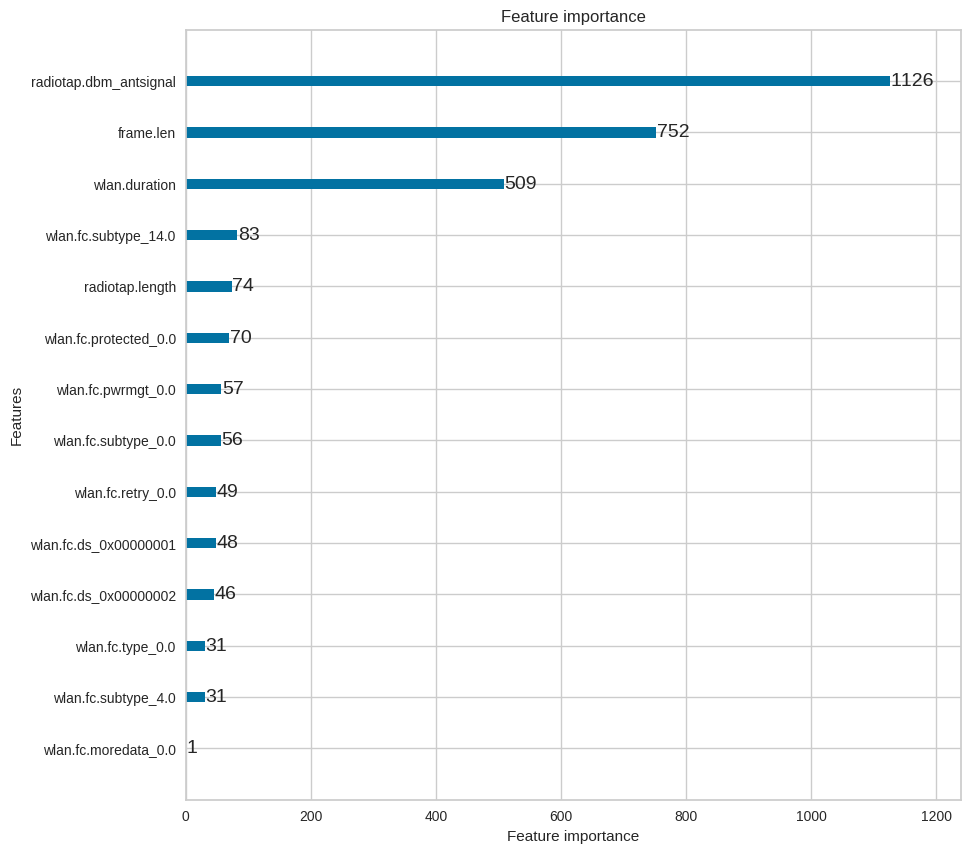

In [7]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99992   0.99304   0.99647     24272
   Evil Twin    0.76062   0.99629   0.86265       539

    accuracy                        0.99311     24811
   macro avg    0.88027   0.99466   0.92956     24811
weighted avg    0.99472   0.99311   0.99356     24811


Confusion Matrix:

True Positive Rate (TPR): 0.99629
False Positive Rate (FPR): 0.00696


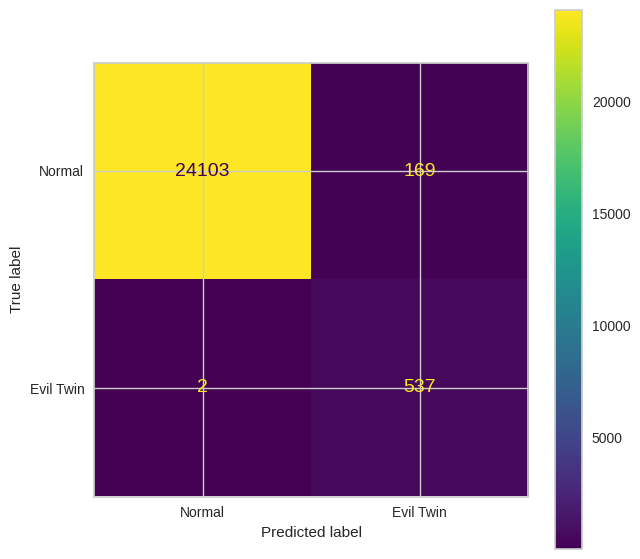

In [8]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test, y_test, ['Normal', 'Evil Twin'], None)

### Training and test with column set

In [9]:
# Numeric columns
numeric_columns = ['frame.len', 'radiotap.dbm_antsignal', 'wlan.duration']

* **Set 1** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.subtype*:

In [10]:
# Select column set (wlan.fc.subtype)
X_res_set_1 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.subtype')
X_test_set_1 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.subtype')

In [11]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_1, y_res, 10, 5, models_path, reports_path, 'set_1')

[LightGBM] [Warning] feature_fraction is set=0.29707135639055376, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29707135639055376
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=1.4763078288421541e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4763078288421541e-05
[LightGBM] [Warning] bagging_fraction is set=0.9635100081050353, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9635100081050353
[LightGBM] [Warning] lambda_l1 is set=6.070075979521504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.070075979521504
[LightGBM] [Warning] feature_fraction is set=0.33784537814601157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.33784537814601157
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.0358900605

[LightGBM] [Warning] feature_fraction is set=0.5168799939136163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168799939136163
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=0.002339075730897134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002339075730897134
[LightGBM] [Warning] bagging_fraction is set=0.9266968250808774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9266968250808774
[LightGBM] [Warning] lambda_l1 is set=0.04183461159153165, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04183461159153165
[LightGBM] [Warning] feature_fraction is set=0.38286017320682963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38286017320682963
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.003707332869

[LightGBM] [Warning] feature_fraction is set=0.6993392776714659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6993392776714659
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=6.219201136403004e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.219201136403004e-08
[LightGBM] [Warning] bagging_fraction is set=0.845005105194281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.845005105194281
[LightGBM] [Warning] lambda_l1 is set=1.5596692816675626e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5596692816675626e-08
[LightGBM] [Warning] feature_fraction is set=0.49024205620917194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49024205620917194
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00031023

[LightGBM] [Warning] feature_fraction is set=0.22612567958595495, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22612567958595495
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.010755032675436899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010755032675436899
[LightGBM] [Warning] bagging_fraction is set=0.46179969527487663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46179969527487663
[LightGBM] [Warning] lambda_l1 is set=2.2284889204345456e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2284889204345456e-08
[LightGBM] [Warning] feature_fraction is set=0.49024205620917194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49024205620917194
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0003

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

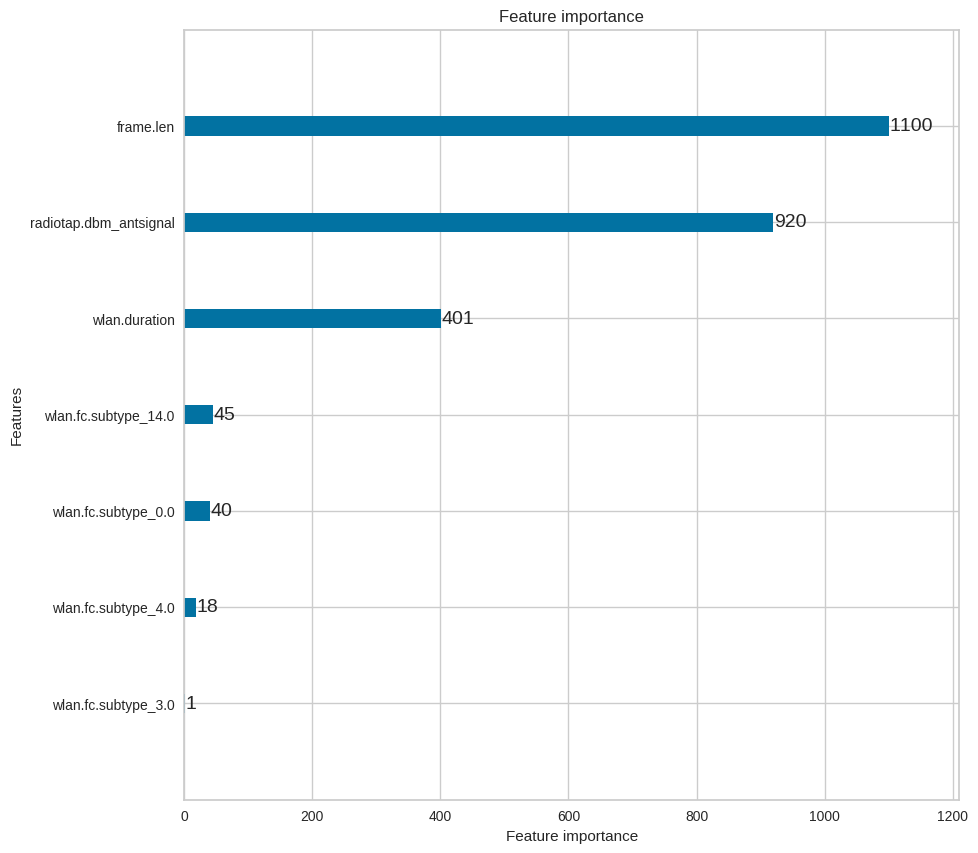

In [12]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99983   0.97536   0.98745     24272
   Evil Twin    0.47220   0.99258   0.63995       539

    accuracy                        0.97574     24811
   macro avg    0.73601   0.98397   0.81370     24811
weighted avg    0.98837   0.97574   0.97990     24811


Confusion Matrix:

True Positive Rate (TPR): 0.99258
False Positive Rate (FPR): 0.02464


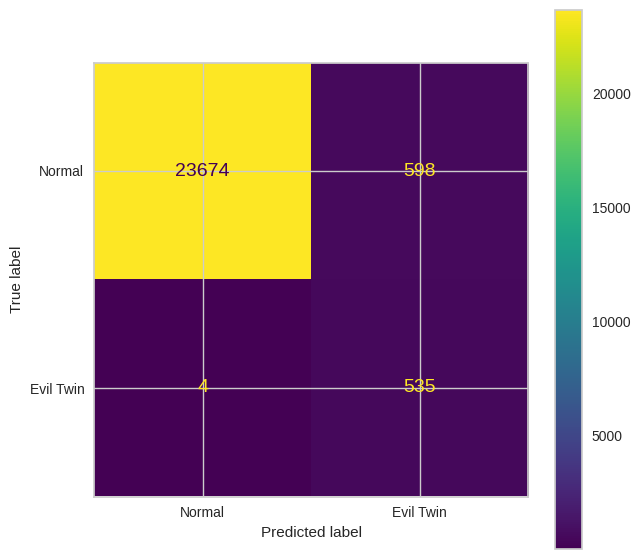

In [13]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_1, y_test, ['Normal', 'Evil Twin'], None)

* **Set 2** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.type*:

In [14]:
# Select column set (wlan.fc.type)
X_res_set_2 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.type')
X_test_set_2 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.type')

In [15]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_2, y_res, 10, 5, models_path, reports_path, 'set_2')

[LightGBM] [Warning] feature_fraction is set=0.980385809967163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.980385809967163
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=6.06140228034165e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.06140228034165e-05
[LightGBM] [Warning] bagging_fraction is set=0.9628741448868088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9628741448868088
[LightGBM] [Warning] lambda_l1 is set=7.996667755170488e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.996667755170488e-08
[LightGBM] [Warning] feature_fraction is set=0.3264242404583364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3264242404583364
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.045472920701

[LightGBM] [Warning] feature_fraction is set=0.5146428510861311, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5146428510861311
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l2 is set=0.0027009438295918916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0027009438295918916
[LightGBM] [Warning] bagging_fraction is set=0.36756170332562943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.36756170332562943
[LightGBM] [Warning] lambda_l1 is set=0.1240636691972219, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1240636691972219
[LightGBM] [Warning] feature_fraction is set=0.735391222412326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735391222412326
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.00078538350315

[LightGBM] [Warning] feature_fraction is set=0.735391222412326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735391222412326
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0007853835031537867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007853835031537867
[LightGBM] [Warning] bagging_fraction is set=0.7607078235407106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7607078235407106
[LightGBM] [Warning] lambda_l1 is set=0.09347379263577149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09347379263577149
[LightGBM] [Warning] feature_fraction is set=0.46208301321251566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46208301321251566
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.27745760769755

[LightGBM] [Warning] feature_fraction is set=0.5898864010418602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5898864010418602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=3.31538691708871e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.31538691708871e-06
[LightGBM] [Warning] bagging_fraction is set=0.9837123237074774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9837123237074774
[LightGBM] [Warning] lambda_l1 is set=1.270709712195899e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.270709712195899e-08
[LightGBM] [Warning] feature_fraction is set=0.649337919804118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.649337919804118
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00898524219681

[LightGBM] [Warning] feature_fraction is set=0.980385809967163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.980385809967163
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=6.06140228034165e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.06140228034165e-05
[LightGBM] [Warning] bagging_fraction is set=0.9628741448868088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9628741448868088
[LightGBM] [Warning] lambda_l1 is set=7.996667755170488e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.996667755170488e-08
[LightGBM] [Warning] feature_fraction is set=0.980385809967163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.980385809967163
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=6.061402280341

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

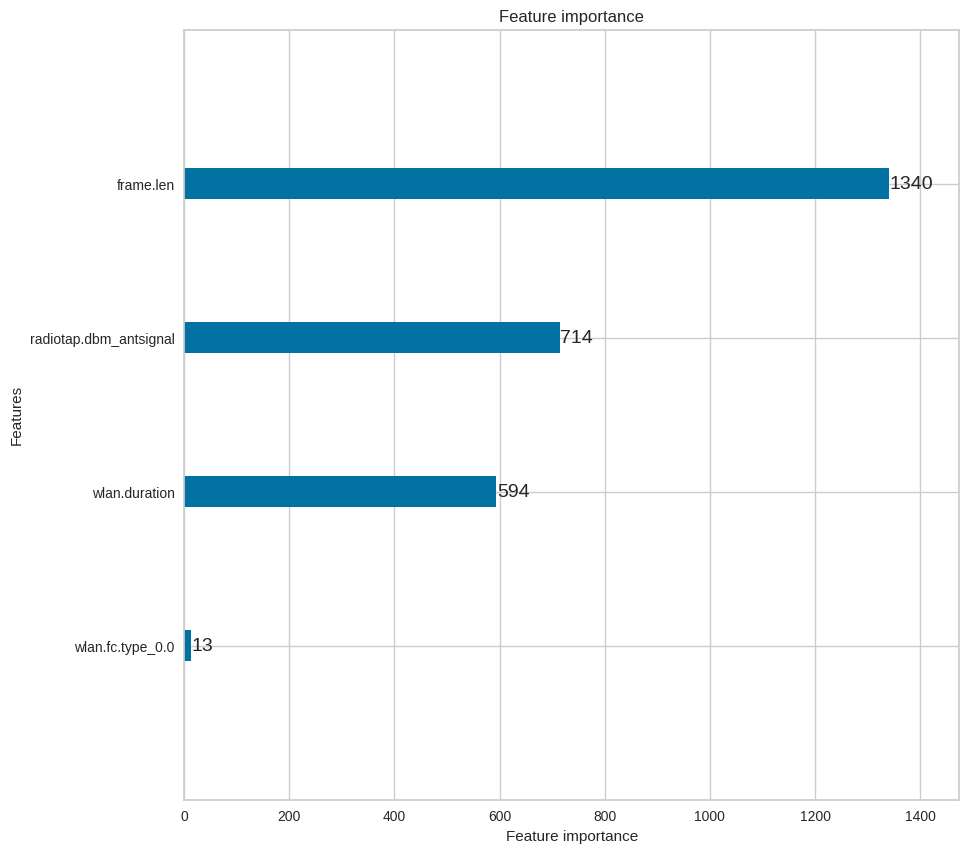

In [16]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99979   0.97240   0.98590     24272
   Evil Twin    0.44352   0.99072   0.61274       539

    accuracy                        0.97279     24811
   macro avg    0.72165   0.98156   0.79932     24811
weighted avg    0.98770   0.97279   0.97780     24811


Confusion Matrix:

True Positive Rate (TPR): 0.99072
False Positive Rate (FPR): 0.0276


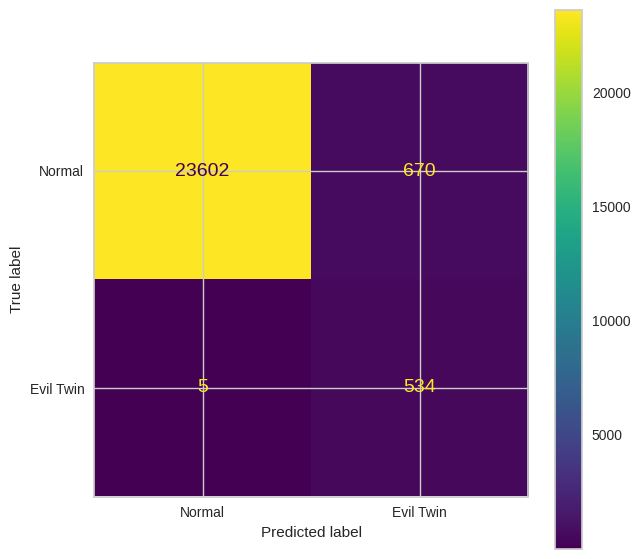

In [17]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_2, y_test, ['Normal', 'Evil Twin'], None)

* **Set 3** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.ds*

In [18]:
# Select column set (wlan.fc.ds)
X_res_set_3 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.ds')
X_test_set_3 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.ds')

In [19]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_3, y_res, 10, 5, models_path, reports_path, 'set_3')

[LightGBM] [Warning] feature_fraction is set=0.15631292036226213, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15631292036226213
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=1.536871963688181e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.536871963688181e-07
[LightGBM] [Warning] bagging_fraction is set=0.4990928210550981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4990928210550981
[LightGBM] [Warning] lambda_l1 is set=0.0008675094756917194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008675094756917194
[LightGBM] [Warning] feature_fraction is set=0.49121590442490237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49121590442490237
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0029

[LightGBM] [Warning] feature_fraction is set=0.5880037100726689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5880037100726689
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=4.6082042487996423e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6082042487996423e-07
[LightGBM] [Warning] bagging_fraction is set=0.5539079986160175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5539079986160175
[LightGBM] [Warning] lambda_l1 is set=0.032970738542418665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032970738542418665
[LightGBM] [Warning] feature_fraction is set=0.21932767671513798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21932767671513798
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=1.0515

[LightGBM] [Warning] feature_fraction is set=0.48113517307590903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48113517307590903
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=5.057132090236575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.057132090236575
[LightGBM] [Warning] bagging_fraction is set=0.43691446550509616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43691446550509616
[LightGBM] [Warning] lambda_l1 is set=3.0395806178217835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0395806178217835
[LightGBM] [Warning] feature_fraction is set=0.49121590442490237, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49121590442490237
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.002946810794256261

[LightGBM] [Warning] feature_fraction is set=0.5880037100726689, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5880037100726689
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=4.6082042487996423e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6082042487996423e-07
[LightGBM] [Warning] bagging_fraction is set=0.5539079986160175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5539079986160175
[LightGBM] [Warning] lambda_l1 is set=0.032970738542418665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032970738542418665
[LightGBM] [Warning] feature_fraction is set=0.48113517307590903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48113517307590903
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=5.057132

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

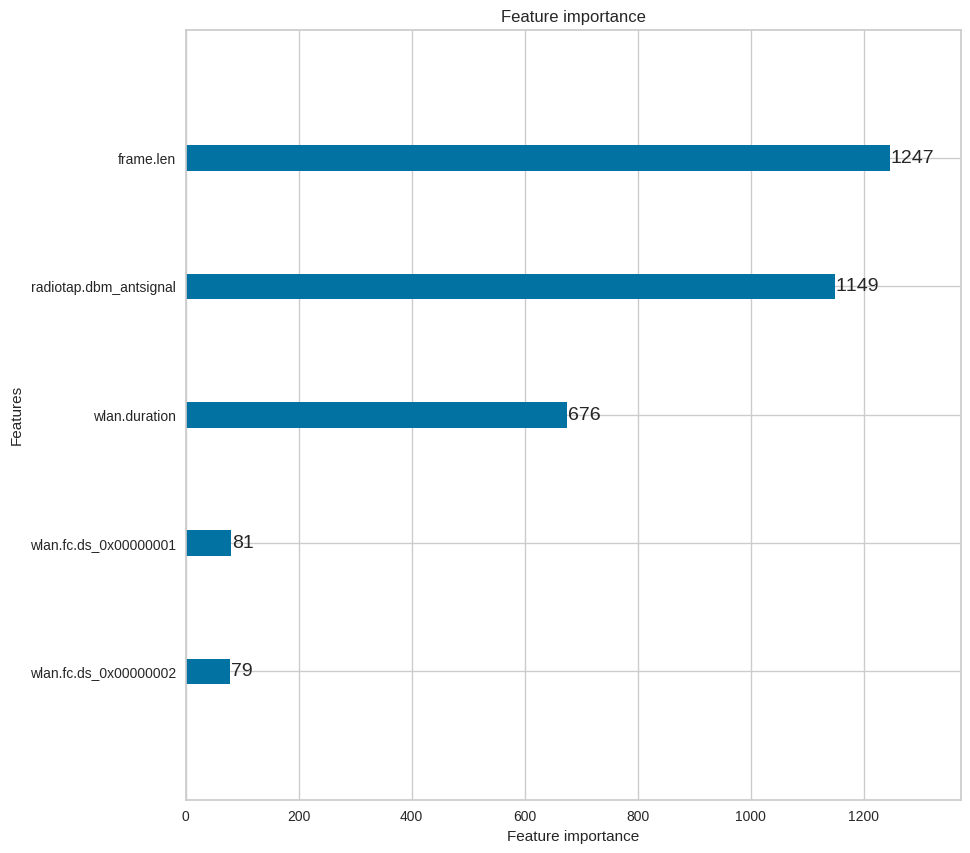

In [20]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99979   0.97553   0.98751     24272
   Evil Twin    0.47340   0.99072   0.64067       539

    accuracy                        0.97586     24811
   macro avg    0.73660   0.98313   0.81409     24811
weighted avg    0.98835   0.97586   0.97997     24811


Confusion Matrix:

True Positive Rate (TPR): 0.99072
False Positive Rate (FPR): 0.02447


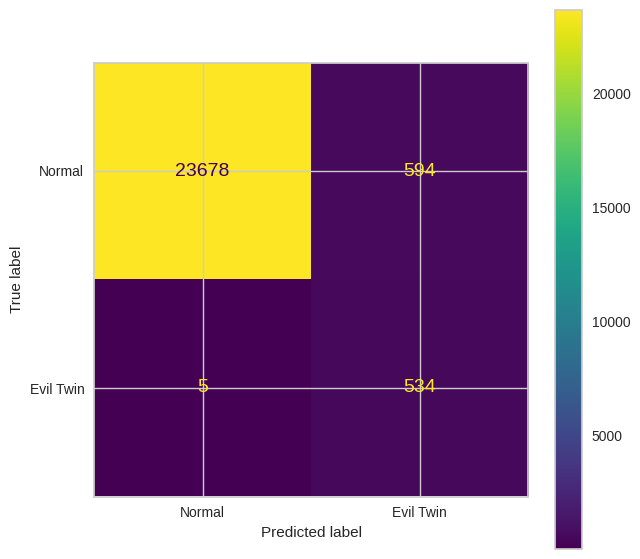

In [21]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_3, y_test, ['Normal', 'Evil Twin'], None)

* **Set 4** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.protected*

In [22]:
# Select column set (wlan.fc.protected)
X_res_set_4 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.protected')
X_test_set_4 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.protected')

In [23]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_4, y_res, 10, 5, models_path, reports_path, 'set_4')

[LightGBM] [Warning] feature_fraction is set=0.1001729332768955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1001729332768955
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.4347909668911043e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4347909668911043e-06
[LightGBM] [Warning] bagging_fraction is set=0.14213453006583268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14213453006583268
[LightGBM] [Warning] lambda_l1 is set=1.609075860870387e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.609075860870387e-06
[LightGBM] [Warning] feature_fraction is set=0.15693438994592984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15693438994592984
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.6078

[LightGBM] [Warning] feature_fraction is set=0.6386657057222117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6386657057222117
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l2 is set=0.00013369168421684826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013369168421684826
[LightGBM] [Warning] bagging_fraction is set=0.6362684409247132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6362684409247132
[LightGBM] [Warning] lambda_l1 is set=7.259899683860514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.259899683860514
[LightGBM] [Warning] feature_fraction is set=0.29766791250110897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29766791250110897
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
[LightGBM] [Warning] lambda_l2 is set=1.7881426218

[LightGBM] [Warning] feature_fraction is set=0.6386657057222117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6386657057222117
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l2 is set=0.00013369168421684826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013369168421684826
[LightGBM] [Warning] bagging_fraction is set=0.6362684409247132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6362684409247132
[LightGBM] [Warning] lambda_l1 is set=7.259899683860514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.259899683860514
[LightGBM] [Warning] feature_fraction is set=0.15693438994592984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15693438994592984
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.607850136796

[LightGBM] [Warning] feature_fraction is set=0.1001729332768955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1001729332768955
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.4347909668911043e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4347909668911043e-06
[LightGBM] [Warning] bagging_fraction is set=0.14213453006583268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.14213453006583268
[LightGBM] [Warning] lambda_l1 is set=1.609075860870387e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.609075860870387e-06
[LightGBM] [Warning] feature_fraction is set=0.4617445469640262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4617445469640262
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=0.0022

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

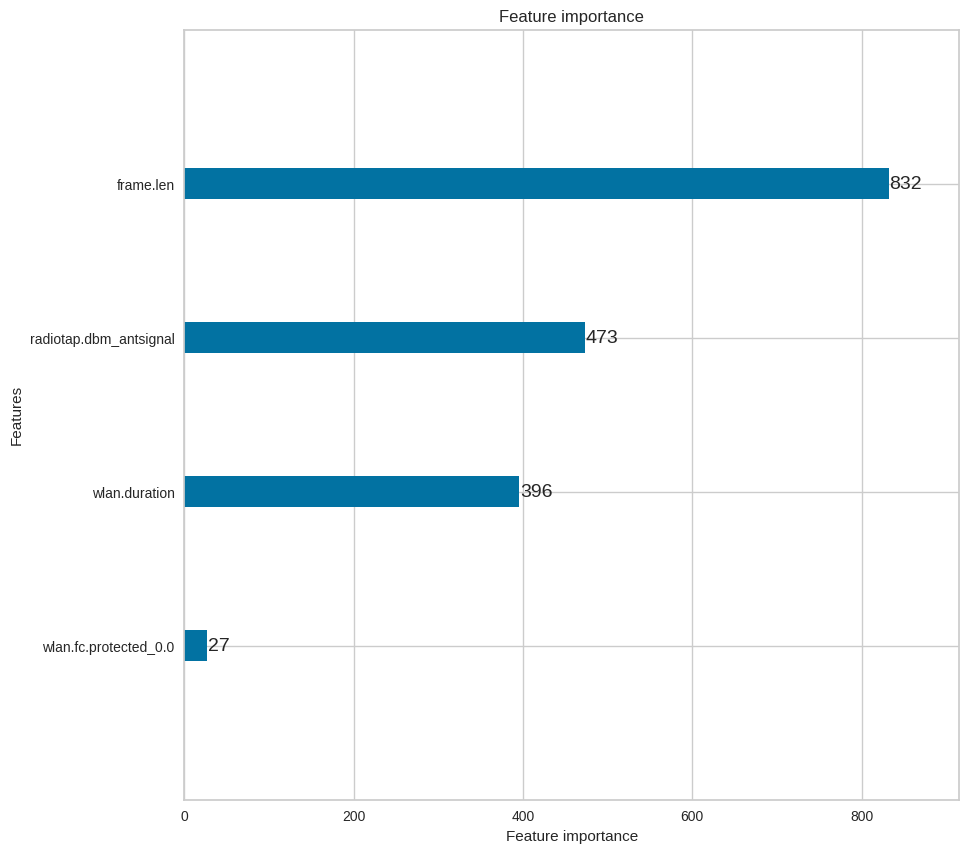

In [24]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    1.00000   0.98949   0.99472     24272
   Evil Twin    0.67884   1.00000   0.80870       539

    accuracy                        0.98972     24811
   macro avg    0.83942   0.99475   0.90171     24811
weighted avg    0.99302   0.98972   0.99068     24811


Confusion Matrix:

True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 0.01051


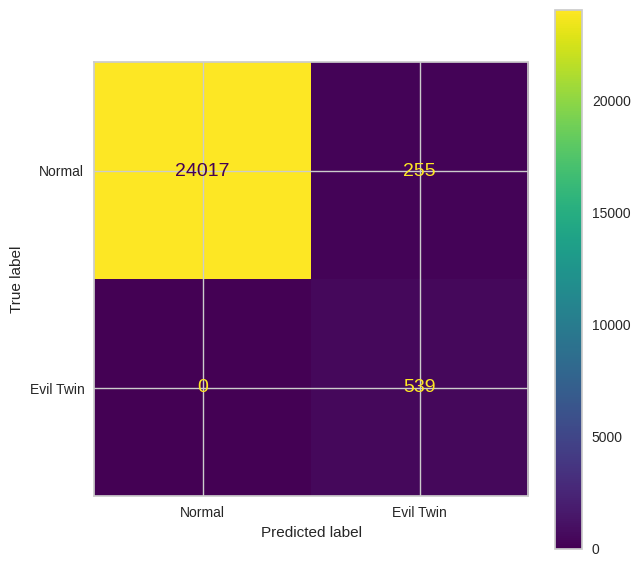

In [25]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_4, y_test, ['Normal', 'Evil Twin'], None)

### Using PyCaret for Automation

Only all columns only.

In [26]:
# Setting up PyCaret
setup = setup(data=train_df, target='Label', fold=5)

,Description,Value
0,Session id,5560
1,Target,Label
2,Target type,Binary
3,Original data shape,"(3147, 24)"
4,Transformed data shape,"(3147, 24)"
5,Transformed train set shape,"(2202, 24)"
6,Transformed test set shape,"(945, 24)"
7,Numeric features,23
8,Preprocess,True
9,Imputation type,simple


In [27]:
# Compare the different models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9936,0.9973,0.9977,0.9866,0.9921,0.9868,0.9869,0.0660
xgboost,Extreme Gradient Boosting,0.9932,0.9991,0.9989,0.9844,0.9916,0.9859,0.9860,0.0760
lightgbm,Light Gradient Boosting Machine,0.9932,0.9993,0.9955,0.9878,0.9915,0.9858,0.9859,0.0400
rf,Random Forest Classifier,0.9927,0.9993,0.9977,0.9844,0.9910,0.9849,0.9850,0.1180
gbc,Gradient Boosting Classifier,0.9927,0.9982,0.9977,0.9844,0.9910,0.9849,0.9850,0.0900
et,Extra Trees Classifier,0.9927,0.9994,0.9977,0.9845,0.9910,0.9849,0.9850,0.1140
ridge,Ridge Classifier,0.9914,0.0000,0.9955,0.9833,0.9893,0.9821,0.9822,0.0160
lda,Linear Discriminant Analysis,0.9914,0.9937,0.9955,0.9833,0.9893,0.9821,0.9822,0.0200
dt,Decision Tree Classifier,0.9900,0.9900,0.9898,0.9855,0.9876,0.9792,0.9793,0.0200
knn,K Neighbors Classifier,0.9886,0.9956,0.9966,0.9757,0.9860,0.9765,0.9767,0.1780


In [28]:
# Select one of the templates to generate
# Here 'lightgbm' will be used
creat_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9955,0.9996,1.0000,0.9888,0.9944,0.9906,0.9906
1,0.9887,0.9995,0.9830,0.9886,0.9858,0.9763,0.9763
2,0.9977,0.9997,1.0000,0.9944,0.9972,0.9953,0.9953
3,0.9864,0.9975,1.0000,0.9670,0.9832,0.9718,0.9721
4,0.9977,1.0000,0.9943,1.0000,0.9972,0.9953,0.9953
Mean,0.9932,0.9993,0.9955,0.9878,0.9915,0.9858,0.9859
Std,0.0048,0.0009,0.0066,0.0112,0.0059,0.0099,0.0098


In [29]:
# Evaluate the selected model
evaluate_model(creat_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [30]:
# Optimize the hyperparameters of the generated model
tuned = tune_model(creat_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9932,0.9993,1.0000,0.9833,0.9916,0.9859,0.9860
1,0.9932,0.9994,1.0000,0.9832,0.9915,0.9859,0.9860
2,0.9955,0.9991,1.0000,0.9888,0.9944,0.9905,0.9906
3,0.9864,0.9981,1.0000,0.9670,0.9832,0.9718,0.9721
4,0.9977,1.0000,1.0000,0.9944,0.9972,0.9953,0.9953
Mean,0.9932,0.9992,1.0000,0.9833,0.9916,0.9859,0.9860
Std,0.0038,0.0006,0.0000,0.0091,0.0047,0.0079,0.0077


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


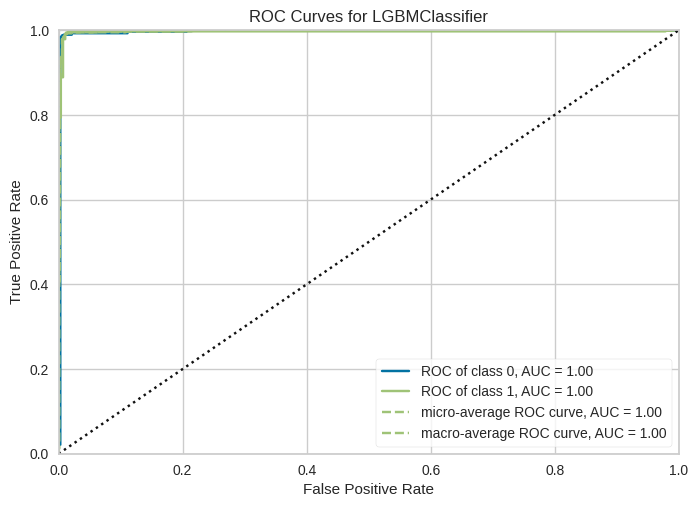

In [31]:
# ROC curve
plot_model(creat_model)

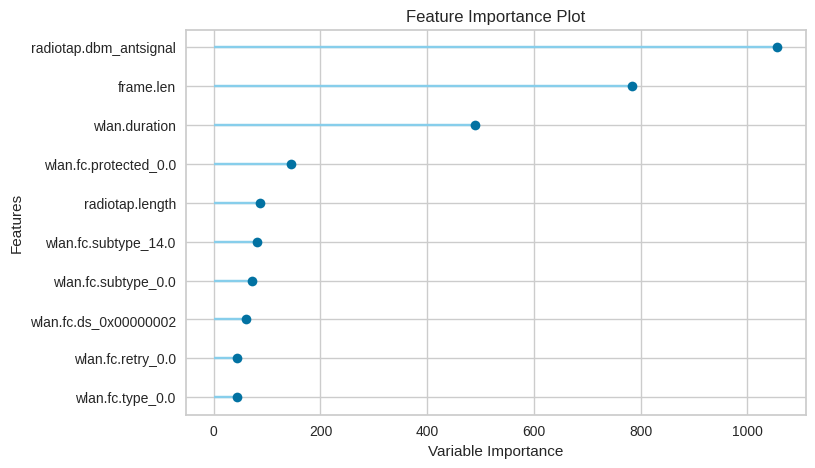

In [32]:
# Feature importance
plot_model(creat_model, plot='feature')

In [33]:
# Save the model
save_model(creat_model, f'{models_path}lightgbm_all_pycaret');

Transformation Pipeline and Model Successfully Saved


			Classification Report


              precision    recall  f1-score   support

      Normal    0.99988   0.99390   0.99688     24272
   Evil Twin    0.78363   0.99443   0.87653       539

    accuracy                        0.99391     24811
   macro avg    0.89175   0.99417   0.93671     24811
weighted avg    0.99518   0.99391   0.99427     24811


Confusion Matrix:

True Positive Rate (TPR): 0.99443
False Positive Rate (FPR): 0.0061


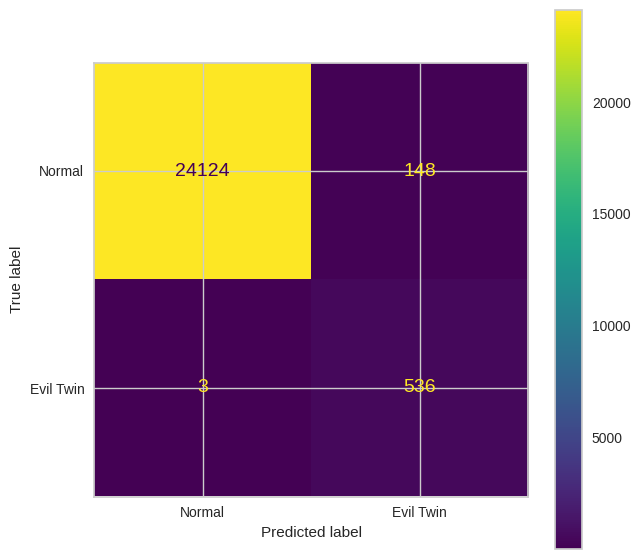

In [34]:
# LightGBM with optimized hyperparameters on test data
report_model(creat_model, X_test, y_test, ['Normal', 'Evil Twin'], None)